# Генерация синтетических данных

В задачах классификации, где наблюдается дизбаланс классов, то есть когда количество примеров одного класса значительно превышает количество примеров другого, возникают серьезные проблемы. Это может привести к тому, что модели машинного обучения будут обучаться на преобладающем классе и игнорировать менее представленный, что в итоге снижает их общую эффективность и способность к обобщению. Для текстовых данных наиболее распространенным и действнным способом решения проблемы дизбаланса классов является генерация синтетических данных.

Импорт библиотек

In [ ]:
import pandas as pd
from gigachat import GigaChat
import json
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим предобработанный датасет

In [ ]:
data = pd.read_csv("../data/clear_data.csv", encoding="utf-8")

data

,Тема,Описание,Тип оборудования,Точка отказа,Серийный номер
0,+BB0EPgRDBEIEMQRDBDo- +BCEEGAQbBBA- +BB0EGg-2-...,Здравствуйте.\n\n Сломался блок...,Ноутбук,Блок питания,C222090381
1,/ шумит кулер / отклеились ножки,"Коллеги, добрый день.\n\nПрошу осуществить заб...",Ноутбук,Вентилятор,C223010310
2,10552. СИЛА HK-1404 // замена блоков питания //,"Добрый день! Не работают блоки питания, прошу ...",Ноутбук,Блок питания,"C223010423, C223011174"
3,10979. Ноутбук СИЛА НК2-1404 // не включается,Добрый день! Ноутбук не включается,Ноутбук,Материнская плата,C223012335
4,BIOS'ы,"Здравствуйте!\nПоделитесь, пожалуйста, последн...",Ноутбук,Консультация,C223010345
...,...,...,...,...,...
180,по неисправной плашке памяти на dd203 - Enclos...,Добрый день!\nПросьба открыть заявку по неиспр...,СХД,Оперативная память,CKM00193800300
181,полосы на матрице НК2-3404,Полосы на матрице.,Ноутбук,Матрица,C223090893
182,полосы на экране и отклеились ножки,Переодически (было 3-4 раза) появляются полосы...,Ноутбук,Матрица,c223012503
183,ремонт ноутбука СИЛА НК2-1404,не работает порт usd и порт type-c на ноутбуке...,Ноутбук,Материнская плата,C223100081


Будем генерировать классы, которых в датасете меньше всего. 

In [ ]:
# Функция, которая ищет самые малочисленные классы

def find_underrepresented_classes(df, column):
    class_counts = df[column].value_counts()
    min_count = class_counts.min()
    return class_counts[class_counts == min_count].index.tolist()

Ниже представлен код для генерации синтетических данных с помощью языковой модели Gigachat. GigaChat разработан как нейросетевая модель, ориентированная на русскоязычную аудиторию. Это делает её особенно подходящей для задач, связанных с генерацией текстов на русском языке. Он может выполнять широкий спектр задач, включая создание текстов, ответы на вопросы и поддержание диалога. GigaChat позиционируется как бесплатный аналог других популярных моделей, что делает его доступным для широкого круга пользователей и разработчиков.

Обратим внимание на то, что Gigachat использовался только для генерации синтетических данных и в итоговом решении он НИКАК НЕ ФИГУРИРУЕТ.

In [ ]:
# Функция для проверки валидности возвращаемого ответа модели
def validate_json(json_string):
    try:
        json.loads(json_string)
        return True
    except ValueError:
        return False
    
def generate_synthetic_data(df, column, save_path):
    ''' Функция для генерации синтетических данных с целью балансировки классов в заданном датафрейме.
    
    Параметры:
    - df (pd.DataFrame): Исходный датафрейм, содержащий данные, которые необходимо сбалансировать.
    - column (str): Название столбца, по которому будет определяться дизбаланс классов.
    - save_path (str): Путь к файлу, куда будут сохраняться обновленные данные.

    Описание работы функции:
    1. Функция сначала определяет классы, которые представлены недостаточно (underrepresented_classes) с помощью вспомогательной функции `find_underrepresented_classes`.
    2. Затем, используя модель GigaChat, функция начинает цикл, который продолжается до тех пор, пока существуют недостаточно представленные классы.
    3. Внутри цикла для каждого недостаточно представленного класса:
        - Случайным образом выбирается одна запись из существующих данных этого класса.
        - Извлекаются значения полей 'Тип оборудования' и 'Точка отказа' для сохранения их в синтетической записи.
        - Формируется запрос (prompt) к модели GigaChat для генерации новой записи, которая будет похожа по смыслу на исходную, но отличаться по тексту.
        - Ответ модели проверяется на корректность формата JSON. Если ответ валиден, он преобразуется в словарь и добавляется в датафрейм.
        - Каждые 10 итераций обновленный датафрейм сохраняется в указанный файл.
    4. Цикл продолжается до тех пор, пока все классы не будут сбалансированы или функция не будет прервана.
    5. В конце итоговый сбалансированный датафрейм сохраняется в файл.

    Возвращает:
    - pd.DataFrame: Обновленный датафрейм с добавленными синтетическими данными.'''
    
    underrepresented_classes = find_underrepresented_classes(df, column)

    with GigaChat(credentials="authorization code", verify_ssl_certs=False) as giga:
        iteration = 0
        while underrepresented_classes:
            for class_name in underrepresented_classes:
                class_data = df[df[column] == class_name]
                row = class_data.sample(n=1).iloc[0]
                
                equipment_type = row['Тип оборудования']
                failure_point = row['Точка отказа']
                
                prompt = f"""Ты пользователь, который обращается в компанию, потому что у тебя проблемы. Сгенерируй одну новую синтетическую запись, похожую по смыслу на эту: {row}, но совсем не похожую по тексту.
                            Не придумывай новых классов для 'Тип оборудования' и 'Точка отказа'.
                            Выдай результат в формате JSON, содержащем все поля: Тема, Описание, Серийный номер.
                            Максимально перефразируй Описание, сохранив смысл.
                            В ответе укажи только JSON.
                        """
                response = giga.chat(prompt)
                synthetic_entry = response.choices[0].message.content.strip()

                if validate_json(synthetic_entry):
                    entry_dict = json.loads(synthetic_entry)

                    entry_dict['Тип оборудования'] = equipment_type
                    entry_dict['Точка отказа'] = failure_point

                    required_fields = ['Тема', 'Описание', 'Тип оборудования', 'Точка отказа', 'Серийный номер']
                    if all(field in entry_dict for field in required_fields):
                        new_row = pd.DataFrame([entry_dict])
                        df = pd.concat([df, new_row], ignore_index=True)
                        iteration += 1
                else:
                    print("Некорректный JSON")

                if iteration % 10 == 0:
                    df.to_csv(save_path, index=False)
                    print(f"Прогресс сохранен {save_path}")

            underrepresented_classes = find_underrepresented_classes(df, column)

    df.to_csv(save_path, index=False)
    print(f"Итоговый датасет сохранен {save_path}")

    return df

## Генерация синтетических данных по всему исходному датасету

Для обучения моделей машинного обучения требуется создать 4 датасета с синтетическими данными:

1) датасет data_balanced_by_equipment, который основан на полном наборе исходных данных и в котором увеличенно число объектов самых меньших по численности классов по столбцу "Тип оборудования". Этот датасет будет использоваться при обучении финальной модели, на которой будет протестирована скрытая выборка.

2) датасет data_balanced_by_failure_point, который основан на полном наборе исходных данных и в котором увеличенно число объектов самых меньших по численности классов по столбцу "Точка выхода". Этот датасет будет использоваться при обучении финальной модели, на которой будет протестирована скрытая выборка.

3) датасет df_train_balanced_by_equipment, который основан на обучающей части исходного набор данных и в котором увеличенно число объектов самых меньших по численности классов по столбцу "Тип оборудования". Этот датасет будет использоваться для выявления метрик качества моделей мшинного обучения и протестирован на тестовой части исходного набора данных.

4) датасет df_train_balanced_by_failure_point, который основан на обучающей части исходного набор данных и в котором увеличенно число объектов самых меньших по численности классов по столбцу "Точка выхода". Этот датасет будет использоваться для выявления метрик качества моделей мшинного обучения и протестирован на тестовой части исходного набора данных.

## 1. Генерация синтетических данных для датасета data_balanced_by_equipment

In [94]:
save_path_equipment = '../data/data_balanced_by_equipment.csv'
save_path_failure_point = '../data/data_balanced_by_failure_point.csv'

In [95]:
if os.path.exists(save_path_equipment):
    df_balanced_by_equipment = pd.read_csv(save_path_equipment)
else:
    df_balanced_by_equipment = data.copy()

if os.path.exists(save_path_failure_point):
    df_balanced_by_failure_point = pd.read_csv(save_path_failure_point)
else:
    df_balanced_by_failure_point = data.copy()

In [ ]:
generate_synthetic_data(df_balanced_by_equipment, 'Тип оборудования', save_path_equipment)

In [96]:
df_balanced_by_equipment = df_balanced_by_equipment.drop_duplicates()

In [97]:
df_balanced_by_equipment

,Тема,Описание,Тип оборудования,Точка отказа,Серийный номер
0,+BB0EPgRDBEIEMQRDBDo- +BCEEGAQbBBA- +BB0EGg-2-...,Здравствуйте.\n\n Сломался блок...,Ноутбук,Блок питания,C222090381
1,/ шумит кулер / отклеились ножки,"Коллеги, добрый день.\n\nПрошу осуществить заб...",Ноутбук,Вентилятор,C223010310
2,10552. СИЛА HK-1404 // замена блоков питания //,"Добрый день! Не работают блоки питания, прошу ...",Ноутбук,Блок питания,"C223010423, C223011174"
3,10979. Ноутбук СИЛА НК2-1404 // не включается,Добрый день! Ноутбук не включается,Ноутбук,Материнская плата,C223012335
4,BIOS'ы,"Здравствуйте!\nПоделитесь, пожалуйста, последн...",Ноутбук,Консультация,C223010345
...,...,...,...,...,...
575,СР2-5422 после обновления BIOS и BMC,Обновили BIOS и BMC на сервере СР2-5422 до пос...,Сервер,Материнская плата,D251110011
579,Неисправность сервера,"Доброго времени суток, уважаемые коллеги. На н...",Сервер,Сервер,D252030012
581,СИЛА СХ2-4115-12; СИЛА CX2-4016-25; СИЛА СХ2-4...,Доброго дня. Нещодавно купили у вас три СХД.,СХД,Консультация,"['E244030004', 'E244030002', 'E244030003']"
586,Открытие заявки по неисправному оборудованию,Здравствуйте! Прошу вас создать заявку по неис...,СХД,Диск,CKM00193901783


Посмотрим на распределение данных после добавления синтетических данных

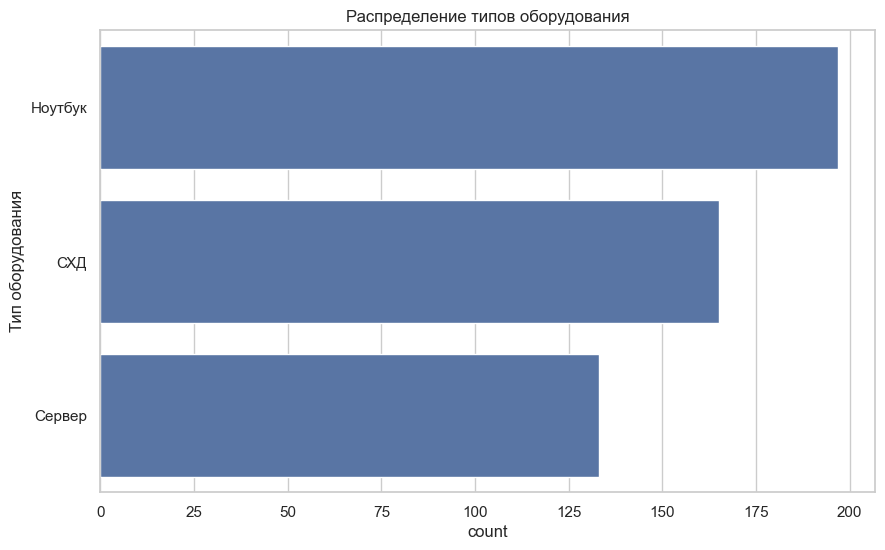

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(y='Тип оборудования', data=df_balanced_by_equipment, order=df_balanced_by_equipment['Тип оборудования'].value_counts().index)
plt.title('Распределение типов оборудования')
plt.show()

Как видим, дизбаланс классов уже не так ощутим.

Сохраним полученный датасет.

In [99]:
df_balanced_by_equipment.to_csv(save_path_equipment, index=False)

## 2. Генерация синтетических данных для датасета df_balanced_by_failure_point

In [ ]:
generate_synthetic_data(df_balanced_by_failure_point, 'Точка отказа', save_path_failure_point)

In [87]:
df_balanced_by_failure_point = df_balanced_by_failure_point.drop_duplicates()

Посмотрим на распределение данных после добавления синтетических данных.

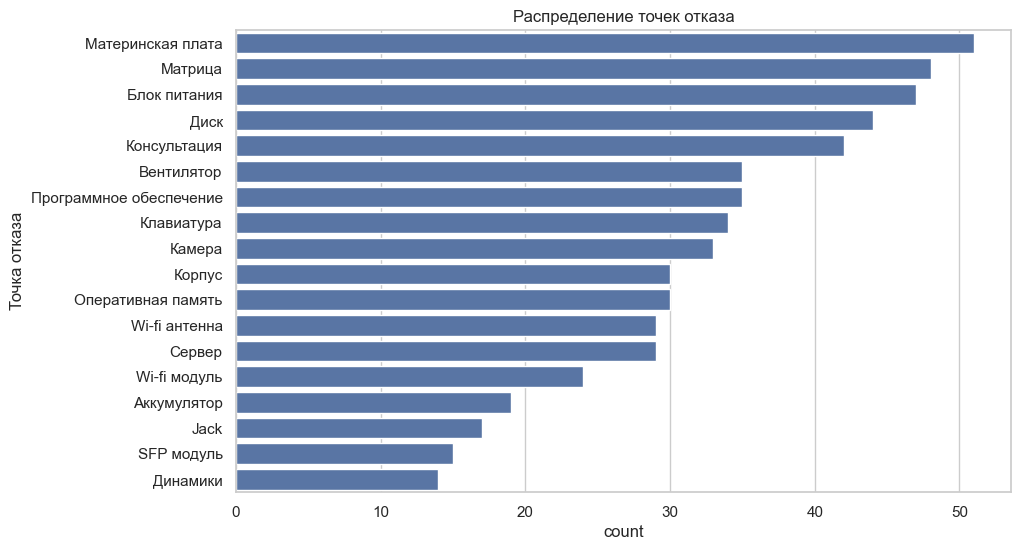

In [88]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Точка отказа', data=df_balanced_by_failure_point, order=df_balanced_by_failure_point['Точка отказа'].value_counts().index)
plt.title('Распределение точек отказа')
plt.show()

Сохраним полученный датасет.

In [89]:
df_balanced_by_failure_point.to_csv(save_path_failure_point, index=False)

## 3. Генерация синтетических данных для датасета df_train_balanced_by_equipment

In [4]:
df = pd.read_csv("../data/df_train.csv", encoding="utf-8")

df

,Тема,Описание,Точка отказа,Серийный номер,Тип оборудования
0,Неисправность Ноутбук СИЛА НК2-3404 - NTB48447...,Добрый день! \r\n Ноутбук СИЛА НК2-3404 - NTB4...,Матрица,C223091505,Ноутбук
1,Гарантийный ремонт Т2,Добрый день. \r\n Прошу произвести гарантийный...,Вентилятор,C223014726,Ноутбук
2,НК2-1404 v2 // Не работает зарядное устройство,Не работает зарядное устройство,Блок питания,C223100822,Ноутбук
3,НК2-1404 // Не работает Wi-FI (Кашира),На устройстве не работает WiFi,Wi-fi антенна,C223101179,Ноутбук
4,Сервер СР2-5422 // После обновления bios и bmc...,Добрый день!\r\nПосле обновления bios и bmc в ...,Вентилятор,D251110031,Сервер
...,...,...,...,...,...
115,Ноутбук Сила НК2-3404,Добрый день.\r\nНам поступили ноутбуки Сила НК...,Консультация,"C223091216, C223091307, C223091468, C223091751...",Ноутбук
116,Ноутбук Сила HK2-3404 (SN: ),Ноутбук Сила HK2-3404 (SN: C223091736)\r\nИз к...,Материнская плата,C223091736,Ноутбук
117,Не включается SILA LLC HK2-3404,Добрый день!\r\nПодскажите пожалуйста что може...,Материнская плата,C223094534,Ноутбук
118,СИЛА HK2-1404// Не работает зарядное устройство,Перестало работать зарядное устройство. С друг...,Блок питания,C223100876,Ноутбук


In [48]:
df2 = pd.read_csv("../data/df_2_train.csv", encoding="utf-8")

df2

,Тема,Описание,Тип оборудования,Точка отказа,Серийный номер
0,СИЛА НК2-1404 // Погнутость крышки // С223012632,"Добрый день, коллеги. Обнаружили погнутость кр...",Ноутбук,Корпус,C223012632
1,Неисправность диска Enclosure=6:Disk=32 dd202,"Коллеги, добрый день.\r\nПрошу открыть кейс по...",СХД,Диск,"E419120013, CKM00194301861"
2,СИЛА НК2-1404// Замена ЗУ на ноутбуках Сила HK...,"Вышли из строя ЗУ от ноутбуков СИЛА НК2-1404, ...",Ноутбук,Блок питания,"C223011170, C223102198, C223011889, C223101201..."
3,FW: Гарантийный случай,Добрый день \r\n по одному из ноутбуков СИЛА Н...,Ноутбук,Блок питания,C223014096
4,Неисправность сервера СИЛА // 46919,"Коллеги, добрый день. \r\n Просьба принять зап...",Сервер,Сервер,D252030014
...,...,...,...,...,...
126,HK2- 1404 // Не работает звук на ноутбуке,"Добрый день,\r\nНе работают звук на ноутбуке, ...",Ноутбук,Jack,C223011358
127,IBS. СИЛА хрипит левый динамик,Добрый день! \r\nНа ноутбуке C111120016 хрипит...,Ноутбук,Динамики,C111120016
128,Заряд аккумулятора,"Отсутствие заряда аккумулятора, использовались...",Ноутбук,Аккумулятор,C223100567
129,Ноутбук СИЛА HK1-1427/ i5-1135G7/16G/m.2 512Gb...,"1. Перезалил, биос уже последний, обновил драй...",Ноутбук,Камера,С111120125


In [4]:
save_path_train_equipment = '../data/df_train_balanced_by_equipment.csv'
save_path_train_failure_point = '../data/df_train_balanced_by_failure_point.csv'

In [7]:
if os.path.exists(save_path_train_equipment):
    df_train_balanced_by_equipment = pd.read_csv(save_path_train_equipment)
else:
    df_train_balanced_by_equipment = df.copy()

if os.path.exists(save_path_train_failure_point):
    df_train_balanced_by_failure_point = pd.read_csv(save_path_train_failure_point)
else:
    df_train_balanced_by_failure_point = df2.copy()

Взглянем на исходное распределение классов по столбцу Точка отказа.

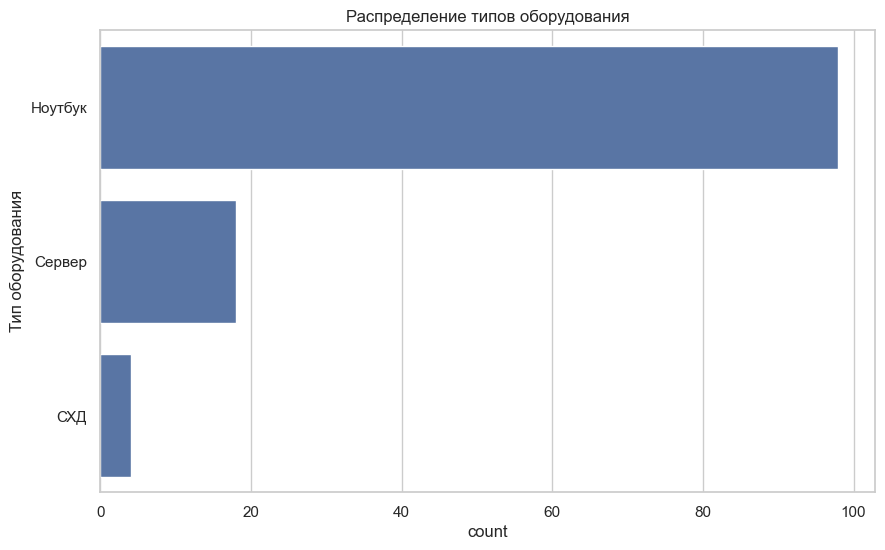

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(y='Тип оборудования', data=df_train_balanced_by_equipment, order=df_train_balanced_by_equipment['Тип оборудования'].value_counts().index)
plt.title('Распределение типов оборудования')
plt.show()

Сгенерируем синтетические данные.

In [ ]:
generate_synthetic_data(df_train_balanced_by_equipment, 'Тип оборудования', save_path_train_equipment)

In [ ]:
if os.path.exists(save_path_train_equipment):
    df_train_balanced_by_equipment = pd.read_csv(save_path_train_equipment)
else:
    df_train_balanced_by_equipment = df.copy()

if os.path.exists(save_path_train_failure_point):
    df_train_balanced_by_failure_point = pd.read_csv(save_path_train_failure_point)
else:
    df_train_balanced_by_failure_point = df.copy()

In [27]:
df_train_balanced_by_equipment = df_train_balanced_by_equipment.drop_duplicates()

Посмотрим, как изменилось распределение по столбцу "Тип оборудования"

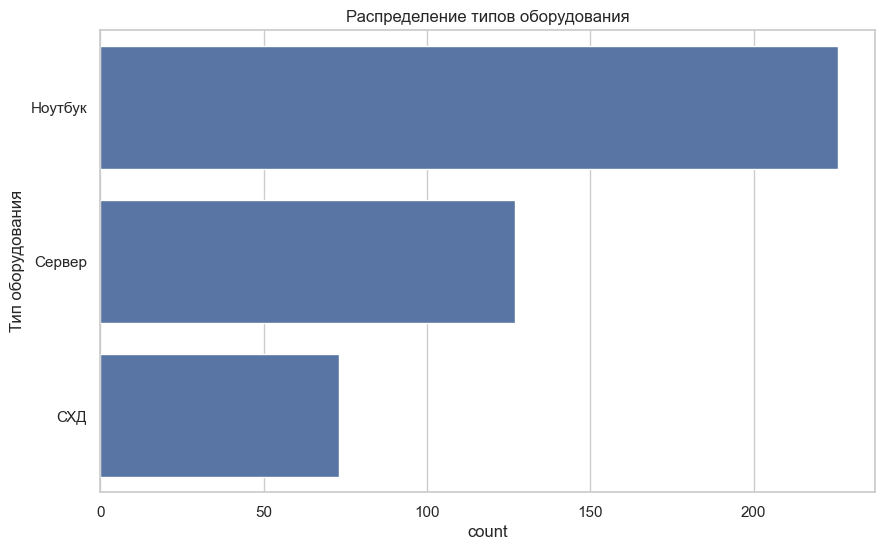

In [28]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(y='Тип оборудования', data=df_train_balanced_by_equipment, order=df_train_balanced_by_equipment['Тип оборудования'].value_counts().index)
plt.title('Распределение типов оборудования')
plt.show()

Сохраним полученный датасет.

In [18]:
df_train_balanced_by_equipment.to_csv(save_path_train_equipment, index=False)

## 4. Генерация синтетических данных для датасета df_train_balanced_by_failure_point

In [21]:
if os.path.exists(save_path_train_equipment):
    df_train_balanced_by_equipment = pd.read_csv(save_path_train_equipment)
else:
    df_train_balanced_by_equipment = df.copy()

if os.path.exists(save_path_train_failure_point):
    df_train_balanced_by_failure_point = pd.read_csv(save_path_train_failure_point)
else:
    df_train_balanced_by_failure_point = df.copy()

Отобразим исходное распределение классов по столбцу "Точка отказа".

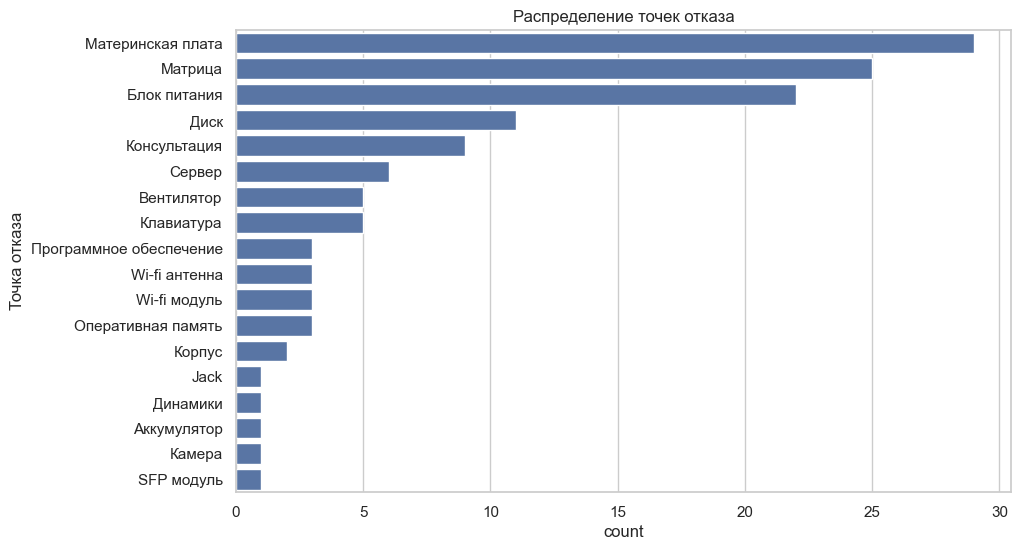

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Точка отказа', data=df_train_balanced_by_failure_point, order=df_train_balanced_by_failure_point['Точка отказа'].value_counts().index)
plt.title('Распределение точек отказа')
plt.show()

Сгенерируем синтетические данные.

In [ ]:
generate_synthetic_data(df_train_balanced_by_failure_point, 'Точка отказа', save_path_train_failure_point)

In [22]:
df_train_balanced_by_failure_point = df_train_balanced_by_failure_point.drop_duplicates()

Посмотрим, как изменилось распределение данных по классам после генерации синтетических данных.

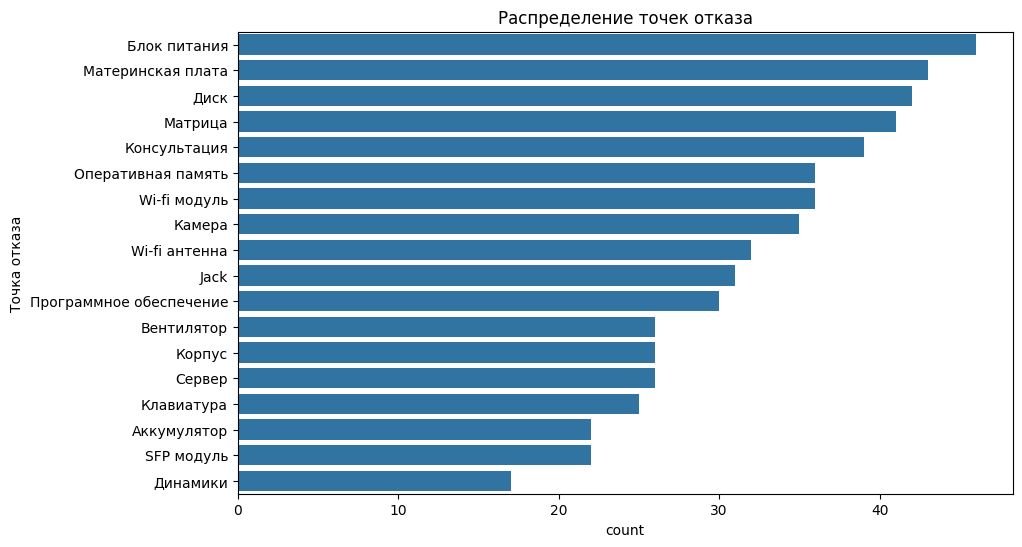

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Точка отказа', data=df_train_balanced_by_failure_point, order=df_train_balanced_by_failure_point['Точка отказа'].value_counts().index)
plt.title('Распределение точек отказа')
plt.show()

Сохраним получившийся датасет.

In [24]:
df_train_balanced_by_failure_point.to_csv(save_path_train_failure_point, index=False)